# Use Reynolds Creek CZO data to create Biome-BGC forcing

__By: Lejo Flores__
__Date: 2020-08-13__

__Purpose:__ This notebook uses a key dataset produced by the Reynolds Creek CZO project (summarized in ) to create the meteorological forcing data needed to run the Biome-BGC 4.2 ecophysiological model for any point in the Reynolds Creek watershed. The notebook uses the `xarray` library to load the meteorological forcing data and find the pixel closest to the point of interest, and then writes the required data to a text file in the format expected by Biome-BGC. Additionally, using the sunrise equation, the notebook computes the length of daylight for each day of interest given the latitude and logitude of the point and the day of the year. 

## 1. Import libraries and set paths, filenames

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import WriteBGCForcing

# Set the relative path to the Reynolds Creek meteorological data daily summary files
rc_metdata_path = '../data/rcczo_daily_climatefields/'

# Set the name of the output meteorological file
bgc_out_fname = './rcczo_johnstondraw.met'

# Point to select: Using Reynolds Mountain East CORE site for example
#x_rcczo_pt = 520468.128677634
#y_rcczo_pt = 4768006.21823093

# Point to select: Using Johnston Draw site for example
x_rcczo_pt = 517181.0
y_rcczo_pt = 4774860.0

# Set the start and end dates for which to create the data. 
# NOTE: The Kormos et al. dataset is written in files containing a single water year.
# A water year extends from 01 October to 30 September of the following calendar year.
start_date = '2005-01-01'
end_date = '2007-12-31'

## 2. Open RC CZO daily met climate fields

In [2]:
# These are names of the Reynolds Creek daily climate summary data. 
# The full file name for maximum daily temperature, for instance, would
# be ta_max_wyYYYY_daily.nc, where YYYY is the year of interest. 
tmax_fname_base = 'ta_max_wy'
tmin_fname_base = 'ta_min_wy'
tmean_fname_base = 'ta_mean_wy'
prcp_fname_base = 'precip_sum_wy'
rh_fname_base = 'rh_mean_wy'
srad_fname_base = 'cloud_solar_mean_wy'

### 2.1 Read daily high temperature into an `xarray` data array object at the point of interest

The algorithm in the cell below is repeated for each variable of interest:
1. The meteorological data files are opened using `xarray.open_mfdataset()`,
2. A `DataArray` is created by selecting all data in time at the pixel nearest to the point of interest,
3. The `DataArray` is subsetted to the period of time from the user-defined start and end dates, and
4. The `DataArray` is subsetted again to remove leap days, as Biome-BGC assumes a 365 day calendar.

In [3]:
ds_tmax = xr.open_mfdataset(rc_metdata_path+tmax_fname_base+'*.nc',combine='by_coords')

da_tmax_pt = ds_tmax.sel(x=x_rcczo_pt,y=y_rcczo_pt,method='nearest')
da_tmax_pt = da_tmax_pt.sel(time=slice(start_date,end_date))
da_tmax_pt = da_tmax_pt.sel(time=~((da_tmax_pt.time.dt.month==2)&(da_tmax_pt.time.dt.day==29)))

ds_tmax.close()

### 2.2 Repeat subset for daily minimum temperature

In [4]:
ds_tmin = xr.open_mfdataset(rc_metdata_path+tmin_fname_base+'*.nc',combine='by_coords')

da_tmin_pt = ds_tmin.sel(x=x_rcczo_pt,y=y_rcczo_pt,method='nearest')
da_tmin_pt = da_tmin_pt.sel(time=slice(start_date,end_date))
da_tmin_pt = da_tmin_pt.sel(time=~((da_tmin_pt.time.dt.month==2)&(da_tmin_pt.time.dt.day==29)))

ds_tmin.close()

### 2.3 Repeat subset for daily mean temperature

In [5]:
ds_tmean = xr.open_mfdataset(rc_metdata_path+tmean_fname_base+'*.nc',combine='by_coords')

da_tmean_pt = ds_tmean.sel(x=x_rcczo_pt,y=y_rcczo_pt,method='nearest')
da_tmean_pt = da_tmean_pt.sel(time=slice(start_date,end_date))
da_tmean_pt = da_tmean_pt.sel(time=~((da_tmean_pt.time.dt.month==2)&(da_tmean_pt.time.dt.day==29)))

ds_tmean.close()

### 2.4 Repeat subset for daily total precipitation

In [6]:
ds_prcp = xr.open_mfdataset(rc_metdata_path+prcp_fname_base+'*.nc',combine='by_coords')

da_prcp_pt = ds_prcp.sel(x=x_rcczo_pt,y=y_rcczo_pt,method='nearest')
da_prcp_pt = da_prcp_pt.sel(time=slice(start_date,end_date))
da_prcp_pt = da_prcp_pt.sel(time=~((da_prcp_pt.time.dt.month==2)&(da_prcp_pt.time.dt.day==29)))

ds_prcp.close()

### 2.5 Repeat subset for daily mean relative humidity

In [7]:
ds_rh = xr.open_mfdataset(rc_metdata_path+rh_fname_base+'*.nc',combine='by_coords')

da_rh_pt = ds_rh.sel(x=x_rcczo_pt,y=y_rcczo_pt,method='nearest')
da_rh_pt = da_rh_pt.sel(time=slice(start_date,end_date))
da_rh_pt = da_rh_pt.sel(time=~((da_rh_pt.time.dt.month==2)&(da_rh_pt.time.dt.day==29)))

ds_rh.close()

### 2.6 Repeat subset for mean solar radiation

In [8]:
ds_srad = xr.open_mfdataset(rc_metdata_path+srad_fname_base+'*.nc',combine='by_coords')

da_srad_pt = ds_srad.sel(x=x_rcczo_pt,y=y_rcczo_pt,method='nearest')
da_srad_pt = da_srad_pt.sel(time=slice(start_date,end_date))
da_srad_pt = da_srad_pt.sel(time=~((da_srad_pt.time.dt.month==2)&(da_srad_pt.time.dt.day==29)))

ds_srad.close()

### 2.7 Now get the data as `numpy` arrays

In [9]:
tmax  = da_tmax_pt['TMAX'].values # Daily maximum temperature [°C]
tmin  = da_tmin_pt['TMIN'].values # Daily minimum temperature [°C]
tmean = da_tmean_pt['TMEAN'].values # Daily mean temperature [°C]
prcp  = da_prcp_pt['precipitation_amount'].values # Daily total precipitation [mm]
rh    = da_rh_pt['relative_humidity'].values # Daily mean relative humidity [0-1]
srad  = da_srad_pt['net_solar'].values # Daily mean solar radiation [W/m^2]

dates = da_tmax_pt.time.values # Get the dates in a datetime64 array

## 3. Plot the data to verify it is correct

### 3.1 Plot maximum, minimum, and mean daily air temperature

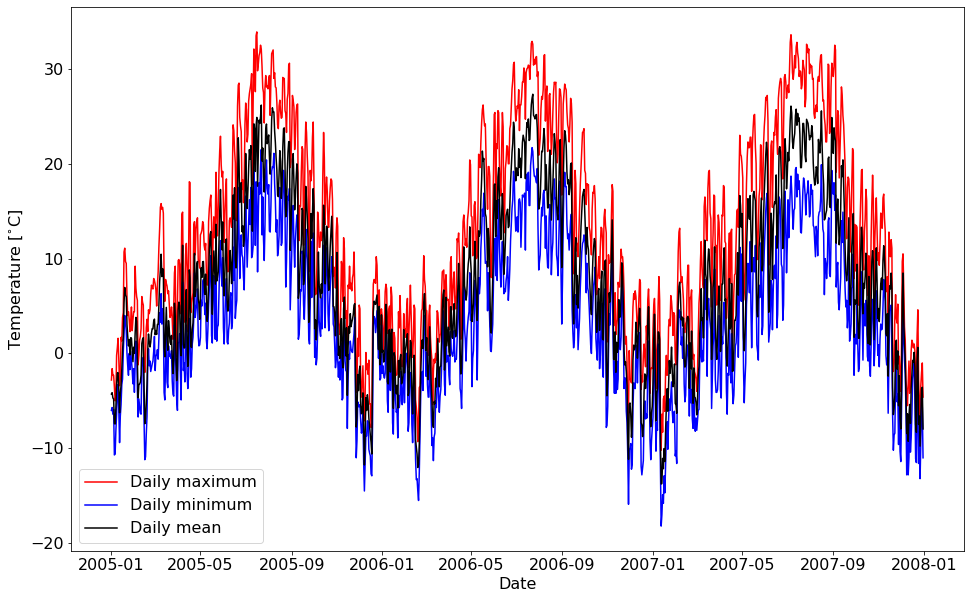

In [10]:
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 16})
plt.plot(dates,tmax,'r',label='Daily maximum')
plt.plot(dates,tmin,'b',label='Daily minimum')
plt.plot(dates,tmean,'k',label='Daily mean')

plt.xlabel('Date')
plt.ylabel('Temperature [${}^{\circ}$C]')
plt.legend()

### 3.2 Plot daily total precipitation

Text(0, 0.5, 'Daily total precipitation [mm]')

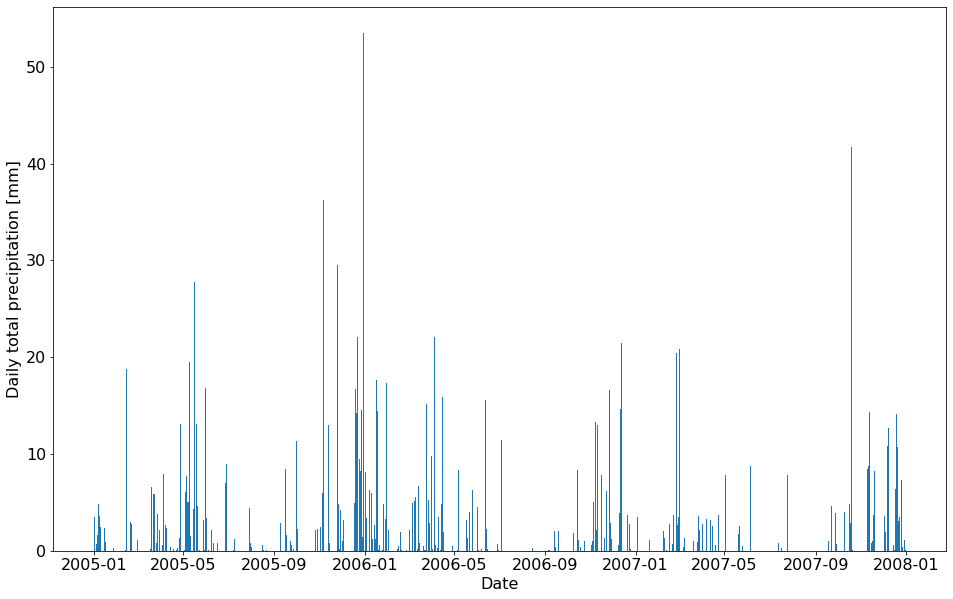

In [11]:
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 16})
plt.bar(dates,prcp)

plt.xlabel('Date')
plt.ylabel('Daily total precipitation [mm]')


### 3.3 Plot daily average solar radiation

Text(0, 0.5, 'Daily Average Solar Radiation [W/m${}^2$]')

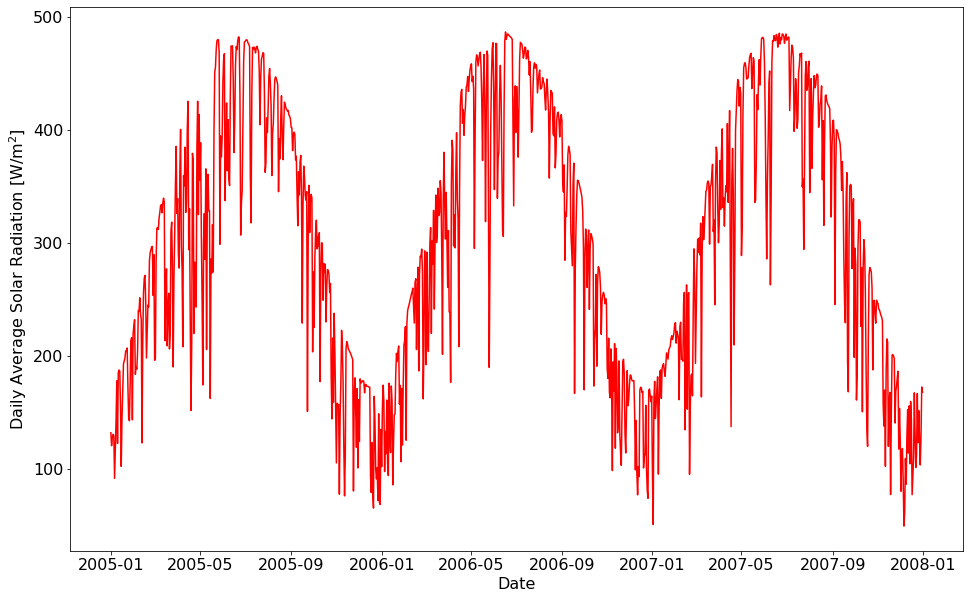

In [12]:
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 16})
plt.plot(dates,srad,'r')

plt.xlabel('Date')
plt.ylabel('Daily Average Solar Radiation [W/m${}^2$]')


## 4. Convert relative humidity into VPD

The Biome-BGC model takes humidity information in the form of vapor pressure deficit (VPD). This requires both the relative humidity and air temperature. We compute the daily average VPD by calculating the saturation vapor pressure using the Clausius-Clapeyron equation with the daily mean temperature. Then the VPD is calculated by multiplying the saturation vapor pressure by one minus the relative humidity

Text(0, 0.5, 'Vapor Pressure Deficit [Pa]')

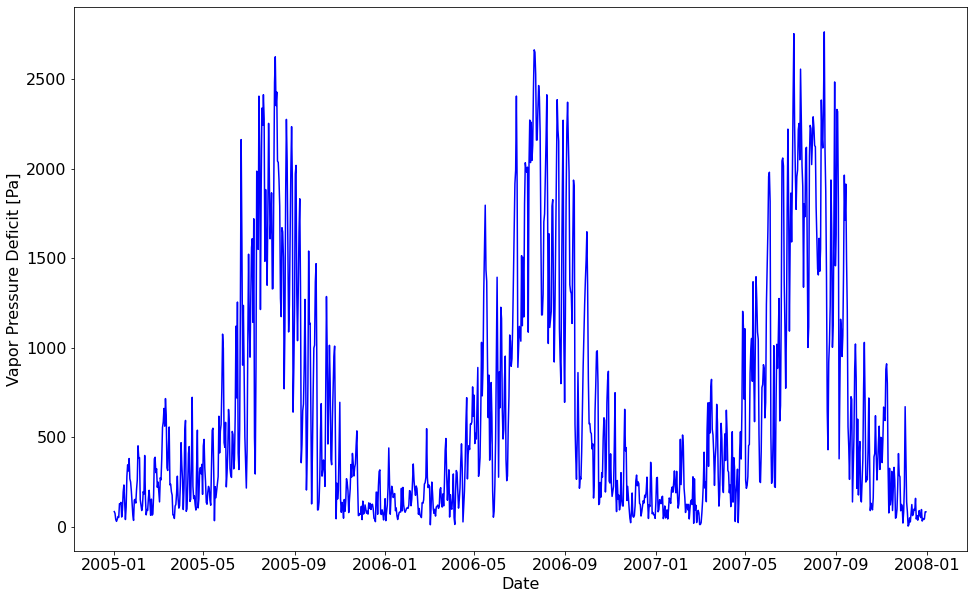

In [13]:
# Calculate saturation vapor pressure based on mean daily temperature
esat = (0.61078*1000.0) * np.exp((17.269*tmean)/(237.3 + tmean)) # In Pa

# Calculate VPD based on esat and relative humidity
VPD = esat*(1.0 - rh)

plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 16})
plt.plot(dates,VPD,'b')

plt.xlabel('Date')
plt.ylabel('Vapor Pressure Deficit [Pa]')

## 5. Calculate day length in seconds

Biome-BGC requires the length of daylight in seconds as input, which is a function principally of the day of the year and the latitude. We can use the so-called Sunrise equation (https://en.wikipedia.org/wiki/Sunrise_equation), a series of spherical trigonometric relationships, to calculate the day length. 

### 5.1 First get the latitude and longitude of the point of interest

In [14]:
lat = da_tmax_pt.lat.values[()]
lon = da_tmax_pt.lon.values[()]

print('Latitude = '+str(lat))
print('Longitude = '+str(lon))

Latitude = 43.12632
Longitude = -116.7887


### 5.2 Use the sunrise equation to calculate the day length

In [15]:
# 1. Calculate the current Julian day
n = (dates - np.datetime64('2000-01-01 12:00:00')) / np.timedelta64(1,'D')

# 2. Calculate mean solar noon in Julian days
Jstar = n - lon / 360.0

# 3. Calculate the solar mean anomaly in degrees and radians
Mdeg = (357.5291 + 0.98560028*Jstar) % 360.0
Mrad = Mdeg*np.pi/180.0

# 4. Calculate the equation of the center in degrees and radians
Cdeg = (1.9148*np.sin(Mrad) + 0.0200*np.sin(2*Mrad) + 0.0003*np.sin(3*Mrad))
Crad = Cdeg*np.pi/180.0

# 5. Calculate the ecliptic longitude in degrees and radians
lambdadeg = ((Mdeg + Cdeg + 180.0 + 102.9372) % 360.0)
lambdarad = lambdadeg*np.pi/180.0

# 6. Calculate the solar transit in Julian days
Jtransit = 2451545.0 + Jstar + 0.0053*np.sin(Mrad) - 0.0069*np.sin(2*lambdarad)

# 7. Calculate the declination of the Sun
sindelta = np.sin(lambdarad) * np.sin(23.44*np.pi/180.0)

# 8. Calculate the hour angle
cosomega0 = (np.sin(-0.83*np.pi/180.0) - np.sin(lat*np.pi/180.0)*sindelta) \
        / (np.cos(lat*np.pi/180.0)*np.cos(np.arcsin(sindelta)))

# 9a. Calculate the sunrise time in Julian days
Jrise = Jtransit - (np.arccos(cosomega0)*180.0/np.pi) / 360.0

# 9b. Calculate the sunset time in Julian days
Jset = Jtransit + (np.arccos(cosomega0)*180.0/np.pi) / 360.0

# 10. Calculate the day length in days and convert to seconds
daylen = (Jset - Jrise)*24.0*3600.0

### 5.3 Plot the day length over the time period of interest to verify

Maximum day length = 15.38
Minimum day length = 8.99


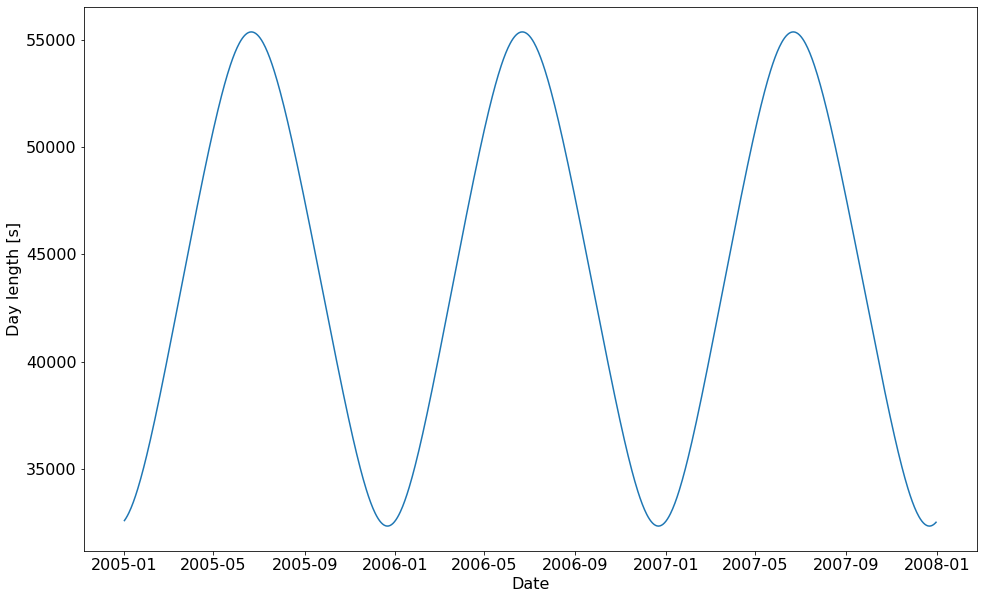

In [16]:
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 16})
plt.plot(dates,daylen)
plt.xlabel('Date')
plt.ylabel('Day length [s]')

print('Maximum day length = '+'{:.2f}'.format(daylen.max() / 3600.0))
print('Minimum day length = '+'{:.2f}'.format(daylen.min() / 3600.0))

In Reynolds Creek, this curve should peak at the Summer Solstice (late June) and reach a minimum during the Winter Solstice (late December). The curve above for the Reynolds Mountain East flux tower ranges between about 9 hours in the winter and 15.4 hours in the summer, which is about as expected. 

## 6. Format and write data to file

### 6.1 Create a large array of output data to write to file

In [17]:
year  = pd.to_datetime(dates).year.values # Get the year associated with each record
yday  = pd.to_datetime(dates).dayofyear.values # Get the day of year associated with each record

mm_to_cm = 0.1 # Used to convert precipitation data from native mm to cm as required by Biome-BGC

OutArray = np.column_stack((year,yday,tmax,tmin,tmean,mm_to_cm*prcp,VPD,srad,daylen))

### 6.2 Write the data to file

Using a function I wrote to accommodate the text formating of the Biome-BGC forcing file, write the data to be used in a Biome-BGC simulation

In [18]:
WriteBGCForcing.WriteBGCForcing('',bgc_out_fname,OutArray)